# Modeling - Binary Classification (Gun vs. Not Gun)

In [1]:
import joblib
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

np.random.seed(42)

In [2]:
# create directions for guns and not guns
data_gun_dir = 'image_data/gun'
data_not_gun_dir = 'image_data/not_gun/'

# new directory for the train test validation split
new_dir = 'split/'

In [3]:
# add gun images 
imgs_gun = [file for file in os.listdir(data_gun_dir) if file.endswith('.jpg')]

In [4]:
# check first ten 
imgs_gun[0:10]

['120px-RugerMuzzelite.jpg',
 'armas (2311).jpg',
 '120px-NEF_B32.jpg',
 'armas (2741).jpg',
 '120px-NambuType14Pistol.jpg',
 'armas (695).jpg',
 'armas (1497).jpg',
 'armas (1182).jpg',
 'armas (380).jpg',
 'armas (1478).jpg']

In [5]:
len(imgs_gun)

3967

In [6]:
# add not gun images
imgs_not_gun = [file for file in os.listdir(data_not_gun_dir) if file.endswith('.jpg')]

In [7]:
imgs_not_gun[0:10]

['-478.jpg',
 'smartphone_0049_box1.jpg',
 'smartphone_0048_box1.jpg',
 '004_0101.jpg',
 '-322.jpg',
 'smartphone_0817_box1.jpg',
 'smartphone_0487_box1.jpg',
 '-444.jpg',
 '-450.jpg',
 'smartphone_0816_box1.jpg']

In [8]:
len(imgs_not_gun)

2150

In [9]:
# below code creates new directory if not already created
# os.mkdir(new_dir)

In [10]:
# from the new directory, create new training, test, and val folders to store the guns and not guns
train_folder = os.path.join(new_dir, 'train')
train_gun = os.path.join(train_folder, 'gun')
train_not_gun = os.path.join(train_folder, 'not_gun')

test_folder = os.path.join(new_dir, 'test')
test_gun = os.path.join(test_folder, 'gun')
test_not_gun = os.path.join(test_folder, 'not_gun')

val_folder = os.path.join(new_dir, 'validation')
val_gun = os.path.join(val_folder, 'gun')
val_not_gun = os.path.join(val_folder, 'not_gun')

In [11]:
# os.mkdir(test_folder)
# os.mkdir(test_gun)
# os.mkdir(test_not_gun)

# os.mkdir(train_folder)
# os.mkdir(train_gun)
# os.mkdir(train_not_gun)

# os.mkdir(val_folder)
# os.mkdir(val_gun)
# os.mkdir(val_not_gun)

Now we will slice the images from `imgs_not_gun` into train, validation, and test folders and do the same for `imgs_gun` into train, validation, and test folders.

**Not Gun Images**

In [12]:
# train not_gun
imgs = imgs_not_gun[:1290]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(train_not_gun, img)
    shutil.copyfile(origin, destination)
# validation not_gun
imgs = imgs_not_gun[1290:1720]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(val_not_gun, img)
    shutil.copyfile(origin, destination)
# test not_gun
imgs = imgs_not_gun[1720:]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(test_not_gun, img)
    shutil.copyfile(origin, destination)

**Gun Images**

In [13]:
# train gun
imgs = imgs_gun[:2270]  # 2270 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(train_gun, img)
    shutil.copyfile(origin, destination)
    
# validation gun
imgs = imgs_gun[2270:3027]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(val_gun, img)
    shutil.copyfile(origin, destination)

# test gun
imgs = imgs_gun[3027:]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(test_gun, img)
    shutil.copyfile(origin, destination)

Check how many images are in each set.

In [14]:
print('There are', len(os.listdir(train_gun)), 'gun images in the train set')
print('There are', len(os.listdir(val_gun)), 'gun images in the validation set')
print('There are', len(os.listdir(test_gun)), 'gun images in the test set')

There are 2392 gun images in the train set
There are 896 gun images in the validation set
There are 940 gun images in the test set


In [15]:
print('There are', len(os.listdir(train_not_gun)), 'not gun images in the train set')
print('There are', len(os.listdir(val_not_gun)), 'not gun images in the validation set')
print('There are', len(os.listdir(test_not_gun)), 'not gun images in the test set')

There are 1290 not gun images in the train set
There are 437 not gun images in the validation set
There are 450 not gun images in the test set


## Preprocessing Images 

- Normalize
- Set up image size
- Set up size of training, validation, and test sets

In [16]:
# get all the data in the directory split/train, and reshape them
# normalizees by rescaling
# set image size to 256 x 256
# batch size varies for each set size

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     train_folder, 
                                                     target_size=(224, 224),
                                                     classes = ['not_gun', 'gun'],
                                                     batch_size=3000) # 3682 total from train

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                   val_folder, 
                                                   target_size=(224, 224),
                                                   classes = ['not_gun', 'gun'],
                                                   batch_size = 1000) # 1333 total from val

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    test_folder, 
                                                    target_size=(224, 224),
                                                    classes = ['not_gun', 'gun'],
                                                    batch_size = 1000) # 1390 total from test

Found 3682 images belonging to 2 classes.
Found 1333 images belonging to 2 classes.
Found 1390 images belonging to 2 classes.


In [17]:
# create the data sets and label the images as gun or not gun
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [18]:
# check shape of images in train set
train_images.shape

(3000, 224, 224, 3)

In [19]:
# check labels for train
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [20]:
train_generator.class_indices

{'not_gun': 0, 'gun': 1}

Label: [1. 0.]


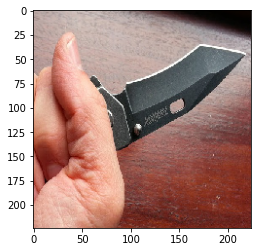

In [21]:
# check an example gun image
sample_train_image = train_images[105]
sample_train_label = train_labels[105]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [0. 1.]


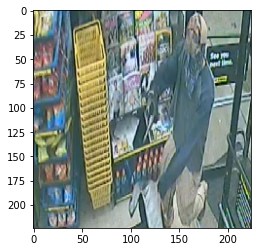

In [22]:
# check an example not gun image
sample_train_image = train_images[0]
sample_train_label = train_labels[0]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [23]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


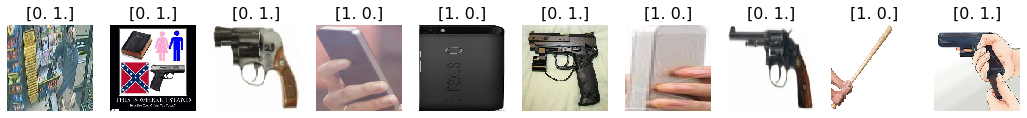

In [24]:
# peek at 10 images in the train set
plots(train_images[0:10], titles = train_labels[0:10])

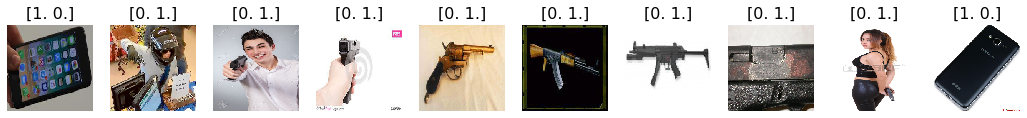

In [25]:
# peek at 10 images in the test set
plots(test_images[500:510], titles = test_labels[500:510])

In [26]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3000
Number of testing samples: 1000
Number of validation samples: 1000
----------------------------------------
train_images shape: (3000, 224, 224, 3)
train_labels shape: (3000, 2)
----------------------------------------
test_images shape: (1000, 224, 224, 3)
test_labels shape: (1000, 2)
----------------------------------------
val_images shape: (1000, 224, 224, 3)
val_labels shape: (1000, 2)


### Reshaping the images

In [27]:
# reshapes the images to (num of images in set, num of pixels ie. 64 x 64 x 3 = 12288)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print("Train", train_img.shape)
print("Validation", val_img.shape)
print("Test", test_img.shape)

Train (3000, 150528)
Validation (1000, 150528)
Test (1000, 150528)


Lets check the class balance for each image set:

In [28]:
# check train labels shape; currently as a binary tuple label
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [29]:
# get array of not gun vs. gun image labels
train_label_sum = sum(train_labels)
val_label_sum = sum(val_labels)
test_label_sum = sum(test_labels)

# get percentage of gun images in each set
train_gun_balance = round(train_label_sum[1] / len(train_labels),3)
val_gun_balance = round(val_label_sum[1] / len(val_labels),3)
test_gun_balance = round(test_label_sum[1] / len(test_labels),3)

print("Percentage of Gun Images in Train Set:", train_gun_balance)
print("Percentage of Gun Images in Validation Set:", val_gun_balance)
print("Percentage of Gun Images in Test Set:", test_gun_balance)


Percentage of Gun Images in Train Set: 0.647
Percentage of Gun Images in Validation Set: 0.667
Percentage of Gun Images in Test Set: 0.671


Finally, to model, we need to reshape the target variable so that it is in the correct shape.

In [30]:
# reshape the target, changes target values to binary (1 or 0)
train_y = np.reshape(train_labels[:,1], (3000,1))
test_y = np.reshape(test_labels[:,1], (1000,1))
val_y = np.reshape(val_labels[:,1], (1000,1))

In [31]:
# check test_y 
test_y[0:15]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [32]:
# verify test_y labels are correct with test set
test_labels[0:15]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
# check change
print(train_y)
print(train_y.shape)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
(3000, 1)


## Build Baseline Dense Network

In [34]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()
baseline_model._name = "Baseline" # names the model

baseline_model.add(layers.Dense(64, activation='relu', input_shape=(150528,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(16, activation='relu'))

baseline_model.add(layers.Dense(1, activation='sigmoid')) 

Metal device set to: Apple M1


2022-08-02 13:36:57.693724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 13:36:57.693864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,636,481
Trainable params: 9,636,481
Non-trainable params: 0
_________________________________________________________________


In [37]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='accuracy', min_delta = 1e-2, patience = 5)

**⏰ Below code runs for a few minutes**

In [38]:
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy', # for binary classification (gun or not gun)
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    train_y,
                                    epochs=50,
                                    batch_size=64,
                                    validation_data=(val_img, val_y),
                                    callbacks=[trainCallback])

Epoch 1/50


2022-08-02 13:37:02.394896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-02 13:37:02.776188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 4.7332 - accuracy: 0.5993

2022-08-02 13:37:06.604508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 5s 94ms/step - loss: 4.7332 - accuracy: 0.5993 - val_loss: 1.2010 - val_accuracy: 0.6640
Epoch 2/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6474 - accuracy: 0.6713 - val_loss: 0.6320 - val_accuracy: 0.7030
Epoch 3/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6098 - accuracy: 0.6917 - val_loss: 1.1191 - val_accuracy: 0.4920
Epoch 4/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6082 - accuracy: 0.7073 - val_loss: 0.7769 - val_accuracy: 0.6010
Epoch 5/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6853 - accuracy: 0.6997 - val_loss: 0.7336 - val_accuracy: 0.6390
Epoch 6/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6693 - accuracy: 0.6943 - val_loss: 1.0537 - val_accuracy: 0.6940
Epoch 7/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6281 - accuracy: 0.7197 - val_loss: 0.7861 - val_accuracy: 0.6220
Epoch 8/50
47/47 [======

## Save the model as a .pkl file

In [39]:
# # use the built-in open() function to open a file
# output_file = open("baseline_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://efbaa532-a94d-4245-aa56-c88dfed6ae9c/assets


In [40]:
# use the built-in open() function again, this time to read
model_file = open("baseline_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_baseline_model = joblib.load(model_file)
# close the file
model_file.close()

In [41]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, train_y, test_img, test_y):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, train_y)
    results_test = mod.model.evaluate(test_img, test_y)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.legend()
    plt.show()

### Baseline Model Results

 1/94 [..............................] - ETA: 15s - loss: 0.5252 - accuracy: 0.8125

2022-08-02 13:41:46.275166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 51ms/step - loss: 0.6674 - accuracy: 0.7470
Train Results Loss: 0.48988
Train Results Accuracy: 0.768
--------------------------------------------------
Test Results Loss: 0.66743
Test Results Accuracy: 0.747


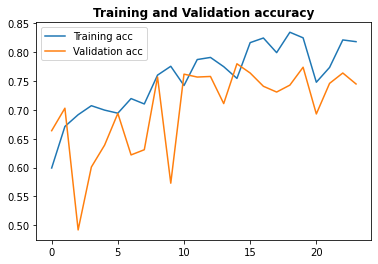

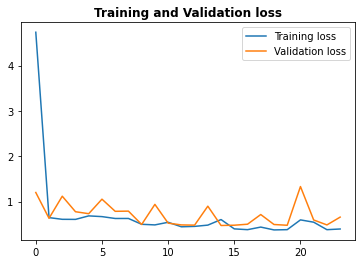

In [42]:
# get baseline model results
model_results(loaded_baseline_model, train_img, train_y, test_img, test_y)

In [43]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = y_proba.round()

    # plot confusion matrix on test set
    cm = confusion_matrix(test_y, predicted)

    disp = ConfusionMatrixDisplay(
        display_labels = ['Not Gun', 'Gun'],
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    
    model_name = mod.model.name

    # labels, title and ticks

    plt.title(model_name + "\nGun & Not Gun Binary Classification Matrix")
    plt.show()
    

 3/32 [=>............................] - ETA: 1s

2022-08-02 13:41:55.608975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 60ms/step


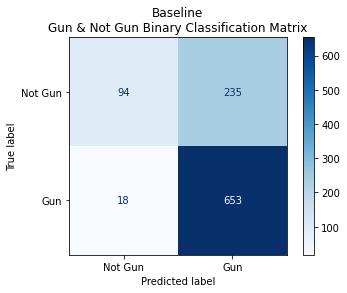

In [44]:
# get confusion matrix and test results for test image set
get_test_results(loaded_baseline_model, test_img, test_y)

## Building a CNN

In [45]:
cnn_model = models.Sequential()
cnn_model._name = "CNN"

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [46]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0       

**⏰ Below code runs for about 8 minutes**

In [47]:
# create a CNN model
cnn_model = cnn_model.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20


2022-08-02 13:42:27.447218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6470

2022-08-02 13:42:42.213117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 18s 356ms/step - loss: 0.6378 - accuracy: 0.6470 - val_loss: 0.6076 - val_accuracy: 0.6660
Epoch 2/20
47/47 [==============================] - 17s 372ms/step - loss: 0.6069 - accuracy: 0.6537 - val_loss: 0.5798 - val_accuracy: 0.6670
Epoch 3/20
47/47 [==============================] - 17s 372ms/step - loss: 0.5900 - accuracy: 0.6573 - val_loss: 0.5600 - val_accuracy: 0.6740
Epoch 4/20
47/47 [==============================] - 17s 372ms/step - loss: 0.5691 - accuracy: 0.6717 - val_loss: 0.7607 - val_accuracy: 0.4600
Epoch 5/20
47/47 [==============================] - 17s 370ms/step - loss: 0.5432 - accuracy: 0.6923 - val_loss: 0.5226 - val_accuracy: 0.7070
Epoch 6/20
47/47 [==============================] - 17s 366ms/step - loss: 0.5372 - accuracy: 0.7037 - val_loss: 0.5130 - val_accuracy: 0.7390
Epoch 7/20
47/47 [==============================] - 18s 376ms/step - loss: 0.5165 - accuracy: 0.7277 - val_loss: 0.4845 - val_accuracy: 0.7420
Epoch 8/20

In [48]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://fb63b82b-31cd-4d68-9c8a-408a533f5ee4/assets


INFO:tensorflow:Assets written to: ram://fb63b82b-31cd-4d68-9c8a-408a533f5ee4/assets


In [49]:
# use the built-in open() function again, this time to read
cnn_model_file = open("cnn_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model = joblib.load(cnn_model_file)
# close the file
cnn_model_file.close()

2022-08-02 13:48:38.196705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 70ms/step - loss: 0.3877 - accuracy: 0.8180
Train Results Loss: 0.31298
Train Results Accuracy: 0.865
--------------------------------------------------
Test Results Loss: 0.38771
Test Results Accuracy: 0.818


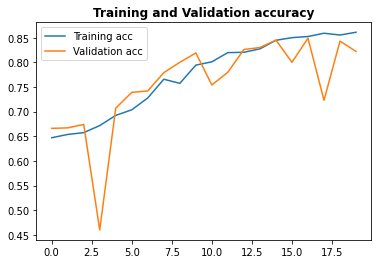

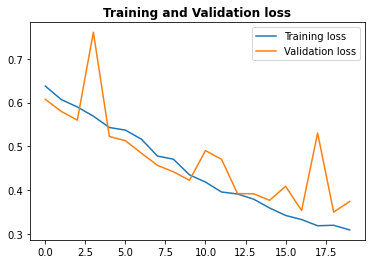

In [50]:
# get baseline model results
model_results(loaded_cnn_model, train_images, train_y, test_images, test_y)

32/32 [==============================] - 2s 72ms/step


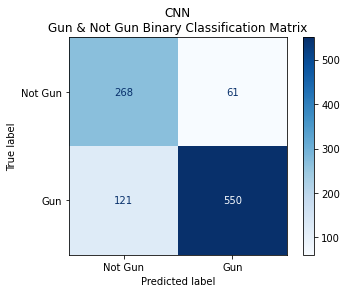

In [52]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model, test_images, test_y)

In [53]:
vgg16_model = keras.applications.vgg16.VGG16()

In [54]:
model_with_vgg16 = models.Sequential()

for layer in vgg16_model.layers:
    model_with_vgg16.add(layer)

In [55]:
model_with_vgg16.pop()

In [56]:
for layer in model_with_vgg16.layers:
    layer.trainable = False


In [57]:
model_with_vgg16.add(layers.Dense(2, activation = 'softmax'))

In [58]:
model_with_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
train_images.shape

In [ ]:
model_with_vgg16.compile(loss='binary_crossentropy',
                          optimizer="sgd",
                          metrics=['accuracy'])

In [ ]:
train_labels

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# create a CNN model
model_with_vgg16 = model_with_vgg16.fit(train_images,
                                        train_labels,
                                        epochs=5,
                                        steps_per_epoch = 30,
                                        validation_data=(val_images, val_labels),
                                        callbacks=[trainCallback])